## **Importing libraries**

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, GlobalAveragePooling1D, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns



## **Loading data**

In [ ]:

# Function to load data from a directory
def load_data_from_folder(folder_path, label):
    data_list = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        data = np.loadtxt(file_path)
        data_list.append(data)
    data_array = np.array(data_list)
    labels = np.array([label] * data_array.shape[0])
    return data_array, labels

# Paths to the folders
paths = {
    'A': '/content/drive/MyDrive/bonn_dataset/Z', # Class 0: Healthy with eyes open
    'B': '/content/drive/MyDrive/bonn_dataset/O', # Class 1: Healthy with eyes closed
    'C': '/content/drive/MyDrive/bonn_dataset/N', # Class 2: Epileptic patient during interictal hippocampal formation
    'D': '/content/drive/MyDrive/bonn_dataset/F', # Class 3: Epileptic patient during interictal epileptogenic zone
    'E': '/content/drive/MyDrive/bonn_dataset/S'  # Class 4: Epileptic patient during a seizure (ictal)
}

def prepare_data_for_classification(classes):
    X, y = [], []
    for label, class_id in enumerate(classes):
        folder_path = paths[class_id]
        data, labels = load_data_from_folder(folder_path, label)
        X.append(data)
        y.append(labels)
    X = np.concatenate(X)
    y = np.concatenate(y)
    return X, y


# Define the LSTM model architecture

In [ ]:
def create_lstm_model(input_shape, units1, units2, dropout1, dropout2, learning_rate):
     # Create a sequential model
    model = Sequential()
    # Add the first LSTM layer with the specified number of units, return sequences, and input shape
    model.add(LSTM(units=units1, return_sequences=True, input_shape=input_shape))
    # Add a dropout layer with the specified dropout rate
    model.add(Dropout(rate=dropout1))
    # Add the second LSTM layer with the specified number of units
    model.add(LSTM(units=units2))
    # Add another dropout layer with the specified dropout rate
    model.add(Dropout(rate=dropout2))
    # Add a dense layer with one unit and sigmoid activation for binary classification
    model.add(Dense(units=1, activation='sigmoid'))
    # Create an Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    # Compile the model with the Adam optimizer, binary cross-entropy loss, and accuracy metric
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    # Return the compiled model
    return model


input_shape: This parameter defines the shape of the input data that will be fed into the LSTM model. In this case, it is a tuple representing the number of time steps and the number of features. For example, if your input data has 100 time steps and 1 feature, the input_shape would be (100, 1).


units1: This parameter specifies the number of units (or neurons) in the first LSTM layer of the model. The number of units determines the capacity of the layer to learn and represent patterns in the data. A higher number of units generally allows the model to learn more complex patterns but can also increase the risk of overfitting.


units2: Similar to units1, this parameter specifies the number of units in the second LSTM layer of the model.


dropout1: This parameter determines the dropout rate for the first dropout layer. Dropout is a regularization technique that helps prevent overfitting by randomly dropping out (setting to zero) a fraction of the units during training. The dropout1 value represents the probability of each unit being dropped out. For example, a dropout1 of 0.2 means that 20% of the units in the first LSTM layer will be randomly dropped out during each training epoch.


dropout2: Similar to dropout1, this parameter specifies the dropout rate for the second dropout layer.
learning_rate: This parameter controls the step size taken by the optimizer during training. The optimizer uses the learning rate to update the model's weights based on the calculated gradients. A smaller learning rate may lead to slower convergence but can help the model find a more optimal solution. A larger learning rate may lead to faster convergence but can also cause the model to overshoot the optimal solution.

# Defining metrics


In [ ]:
def compute_metrics(y_true, y_pred):
    y_pred_labels = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred_labels)
    sensitivity = recall_score(y_true, y_pred_labels, pos_label=1)
    specificity = recall_score(y_true, y_pred_labels, pos_label=0)
    f1 = f1_score(y_true, y_pred_labels)
    return accuracy, sensitivity, specificity, f1

# Model training and evaluation

In [ ]:
def train_and_evaluate_lstm_model(X_train, y_train, X_test, y_test, units1, units2, dropout1, dropout2, learning_rate, batch_size):
    model = create_lstm_model((X_train.shape[1], 1), units1, units2, dropout1, dropout2, learning_rate)

    # Display the model architecture
    model.summary()

    # Train the model and store the history
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=batch_size, verbose=1)

    # Plot the training history (loss and accuracy)
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    score = model.evaluate(X_test, y_test, verbose=1)

    # Compute accuracy, sensitivity, specificity, F1
    accuracy, sensitivity, specificity, f1 = compute_metrics(y_test, y_pred)

    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {accuracy}')
    print(f'Sensitivity (Recall): {sensitivity}')
    print(f'Specificity: {specificity}')
    print(f'F1 Score: {f1}')

    # Plot the confusion matrix
    y_pred_labels = (y_pred > 0.5).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_labels)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return model

 A-B vs. C-D-E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 4097, 150)           │          91,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4097, 150)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 100)                 │         100,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 191,701 (748.83 KB)

 Trainable params: 191,701 (748.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 139s 14s/step - accuracy: 0.5684 - loss: 0.6794 - val_accuracy: 0.6000 - val_loss: 0.6084
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 136s 14s/step - accuracy: 0.6366 - loss: 0.6005 - val_accuracy: 0.6000 - val_loss: 0.5720
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 138s 13s/step - accuracy: 0.5828 - loss: 0.5915 - val_accuracy: 0.7375 - val_loss: 0.5286
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 142s 14s/step - accuracy: 0.6715 - loss: 0.7264 - val_accuracy: 0.6500 - val_loss: 0.5239
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 134s 13s/step - accuracy: 0.5990 - loss: 0.5821 - val_accuracy: 0.6625 - val_loss: 0.5147
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 139s 13s/step - accuracy: 0.6503 - loss: 0.5532 - val_accuracy: 0.7625 - val_loss: 0.5274
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 144s 13s/step - accuracy: 0.7065 - loss: 0.5908 - val_accuracy: 0.7750 - val_loss: 0.4767
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 142s 13s/step - accuracy: 0.6476 - loss: 0.5594 - val_accuracy: 0.

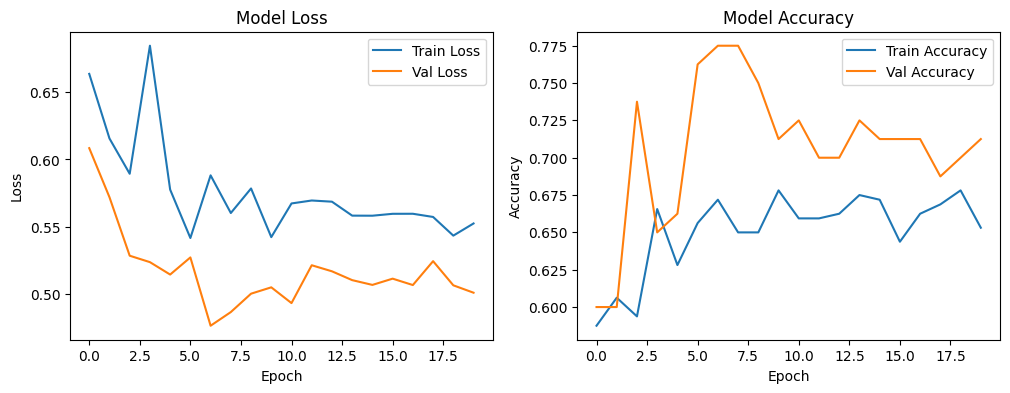

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7816 - loss: 0.4755
Test loss: 0.47277870774269104
Test accuracy: 0.79
Sensitivity (Recall): 0.6379310344827587
Specificity: 1.0
F1 Score: 0.7789473684210527


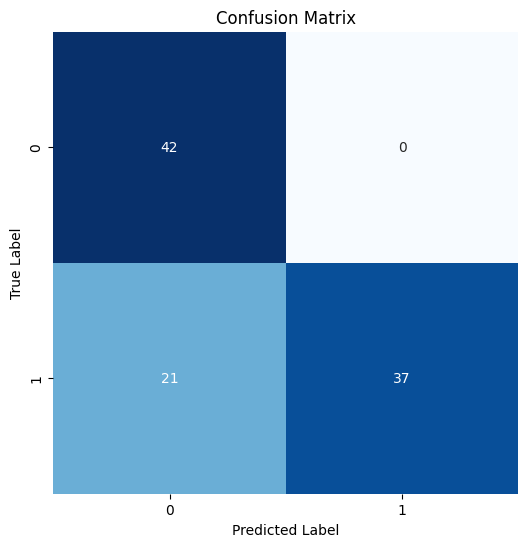

<Sequential name=sequential_2, built=True>

In [ ]:
# Example for training the model on A-B vs C-D-E classes
classes_ab = ['A', 'B']
classes_cde = ['C', 'D', 'E']
X_ab, y_ab = prepare_data_for_classification(classes_ab)
X_cde, y_cde = prepare_data_for_classification(classes_cde)

# Merge and create new labels
X = np.concatenate([X_ab, X_cde])
y = np.concatenate([np.zeros(len(y_ab)), np.ones(len(y_cde))])  # 0 for A-B, 1 for C-D-E

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data for RNN
X = X.reshape(X.shape[0], X.shape[1], 1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the LSTM model
train_and_evaluate_lstm_model(X_train, y_train, X_test, y_test, units1=150, units2=100, dropout1=0.2, dropout2=0.3, learning_rate=0.001, batch_size=32)

A-E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 4097, 120)           │          58,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4097, 120)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          47,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 105,985 (414.00 KB)

 Trainable params: 105,985 (414.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step - accuracy: 0.5260 - loss: 0.6898 - val_accuracy: 0.5312 - val_loss: 0.6753
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 9s/step - accuracy: 0.6302 - loss: 0.6622 - val_accuracy: 0.5312 - val_loss: 0.6492
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 9s/step - accuracy: 0.6823 - loss: 0.6252 - val_accuracy: 0.6250 - val_loss: 0.5780
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step - accuracy: 0.7552 - loss: 0.5608 - val_accuracy: 0.8750 - val_loss: 0.4149
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 9s/step - accuracy: 0.8167 - loss: 0.4307 - val_accuracy: 0.9688 - val_loss: 0.1998
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 9s/step - accuracy: 0.9250 - loss: 0.2330 - val_accuracy: 0.9688 - val_loss: 0.2573
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step - accuracy: 0.9635 - loss: 0.2124 - val_accuracy: 0.9062 - val_loss: 0.2732
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 9s/step - accuracy: 0.9240 - loss: 0.2287 - val_accuracy: 0.9688 - val_loss: 0.2063
Epoch 9/

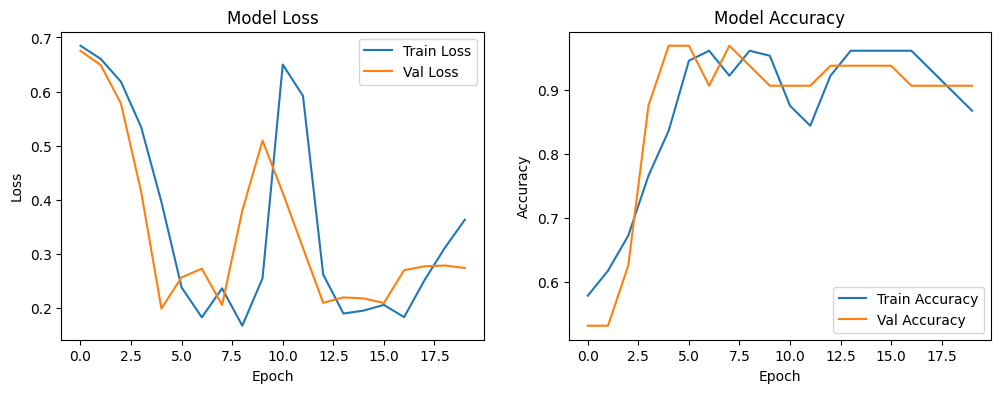

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 937ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 646ms/step - accuracy: 0.7562 - loss: 0.6043
Test loss: 0.5635231137275696
Test accuracy: 0.775
Sensitivity (Recall): 1.0
Specificity: 0.5714285714285714
F1 Score: 0.8085106382978724


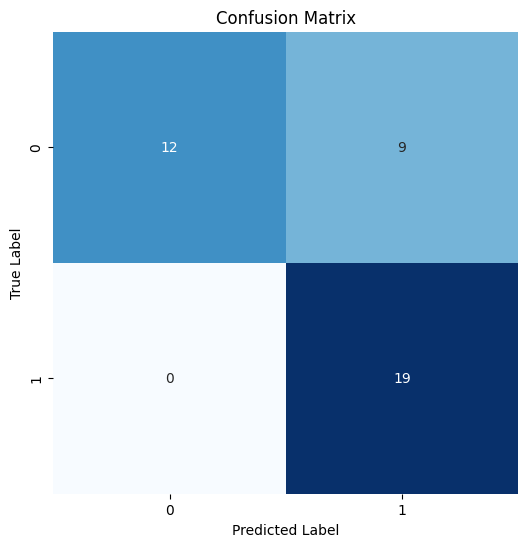

<Sequential name=sequential_2, built=True>

In [ ]:
# Load and preprocess data for classes A and E
classes = ['A', 'E']
X, y = prepare_data_for_classification(classes)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)


# Reshape data for RNN
X = X.reshape(X.shape[0], X.shape[1], 1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the LSTM model
train_and_evaluate_lstm_model(X_train, y_train, X_test, y_test, units1=120, units2=64, dropout1=0.3, dropout2=0.3, learning_rate=0.001, batch_size= 32)


B-E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 4097, 128)           │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4097, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step - accuracy: 0.5188 - loss: 0.6923 - val_accuracy: 0.7812 - val_loss: 0.6595
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 9s/step - accuracy: 0.6677 - loss: 0.6712 - val_accuracy: 0.6562 - val_loss: 0.6295
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - accuracy: 0.6438 - loss: 0.6428 - val_accuracy: 0.7812 - val_loss: 0.5448
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step - accuracy: 0.7812 - loss: 0.5356 - val_accuracy: 0.9062 - val_loss: 0.3623
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.8479 - loss: 0.4330 - val_accuracy: 0.9062 - val_loss: 0.2536
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 9s/step - accuracy: 0.8917 - loss: 0.3296 - val_accuracy: 0.9375 - val_loss: 0.1746
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 9s/step - accuracy: 0.9427 - loss: 0.1693 - val_accuracy: 1.0000 - val_loss: 0.0369
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 9s/step - accuracy: 0.9698 - loss: 0.1205 - val_accuracy: 1.0000 - val_loss: 0.0276
Epoch 9/

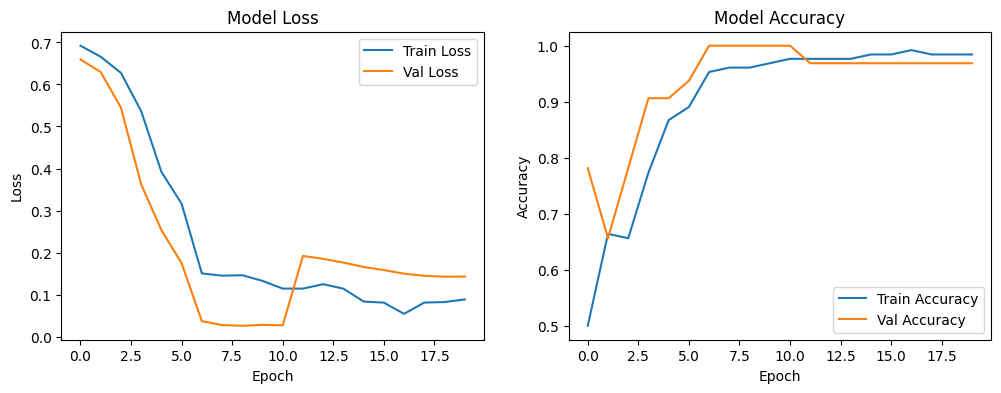

1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9458 - loss: 0.2372
Test loss: 0.21997570991516113
Test accuracy: 0.95
Sensitivity (Recall): 1.0
Specificity: 0.9047619047619048
F1 Score: 0.9500000000000001


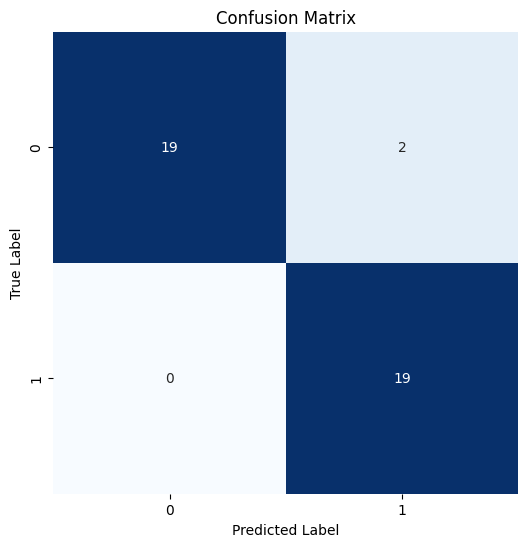

<Sequential name=sequential_3, built=True>

In [ ]:
# Load and preprocess data for classes B and D
classes = ['B', 'E']
X, y = prepare_data_for_classification(classes)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data for RNN
X = X.reshape(X.shape[0], X.shape[1], 1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the LSTM model
train_and_evaluate_lstm_model(X_train, y_train, X_test, y_test,
                              units1=128, units2=64,
                              dropout1=0.2, dropout2=0.2,
                              learning_rate=0.001,
                              batch_size=32)


A-C

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4097, 256)           │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4097, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 461,441 (1.76 MB)

 Trainable params: 461,441 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 110s 26s/step - accuracy: 0.4417 - loss: 0.6938 - val_accuracy: 0.4688 - val_loss: 0.6940
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 94s 24s/step - accuracy: 0.5156 - loss: 0.6929 - val_accuracy: 0.4688 - val_loss: 0.6949
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 99s 25s/step - accuracy: 0.5177 - loss: 0.6913 - val_accuracy: 0.4688 - val_loss: 0.6951
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 139s 25s/step - accuracy: 0.5115 - loss: 0.6921 - val_accuracy: 0.4688 - val_loss: 0.6953
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 141s 24s/step - accuracy: 0.5281 - loss: 0.6949 - val_accuracy: 0.4688 - val_loss: 0.6955
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 140s 24s/step - accuracy: 0.5167 - loss: 0.6936 - val_accuracy: 0.4688 - val_loss: 0.6957
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 151s 27s/step - accuracy: 0.5156 - loss: 0.6927 - val_accuracy: 0.4688 - val_loss: 0.6965
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 136s 25s/step - accuracy: 0.5542 - loss: 0.6900 - val_accuracy: 0.4688 - val_loss: 0

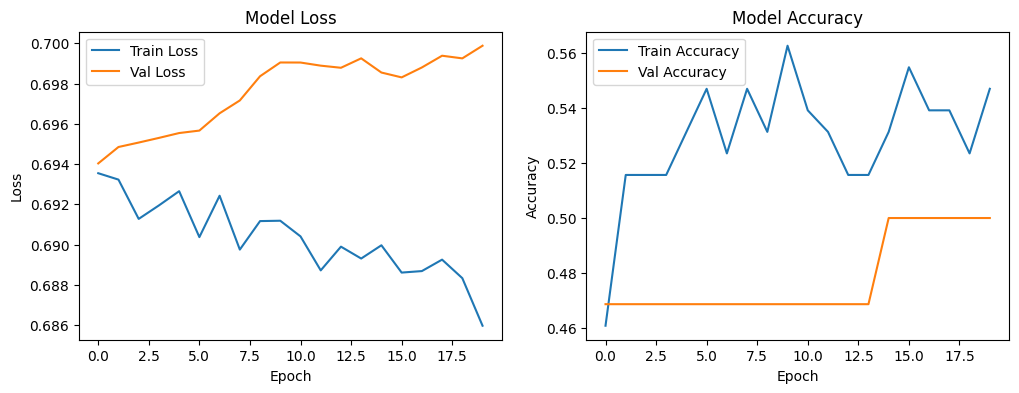

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.5875 - loss: 0.6774
Test loss: 0.6714199185371399
Test accuracy: 0.6
Sensitivity (Recall): 0.7368421052631579
Specificity: 0.47619047619047616
F1 Score: 0.6363636363636364


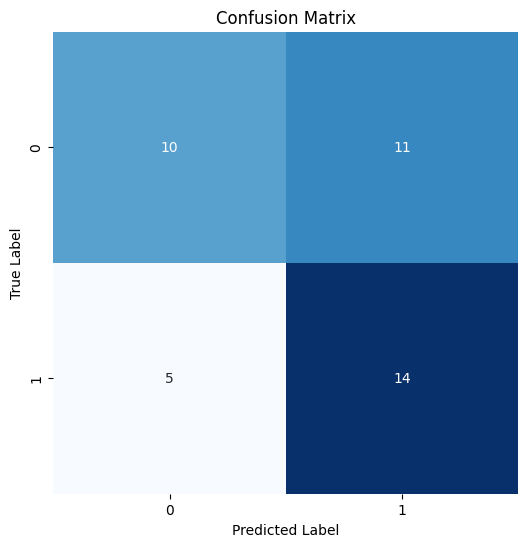

<Sequential name=sequential, built=True>

In [ ]:
# Load and preprocess data for classes A and c
classes = ['A', 'C']
X, y = prepare_data_for_classification(classes)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data for RNN
X = X.reshape(X.shape[0], X.shape[1], 1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the LSTM model
train_and_evaluate_lstm_model(X_train, y_train, X_test, y_test,
                              units1=256, units2=128,
                              dropout1=0.15, dropout2=0.25,
                              learning_rate=0.0001,
                              batch_size=32)


B-D

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 4097, 200)           │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 4097, 200)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 100)                 │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 282,101 (1.08 MB)

 Trainable params: 282,101 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 86s 11s/step - accuracy: 0.4284 - loss: 0.6979 - val_accuracy: 0.3125 - val_loss: 0.6990
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 91s 12s/step - accuracy: 0.5083 - loss: 0.6872 - val_accuracy: 0.4375 - val_loss: 0.7088
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 139s 11s/step - accuracy: 0.4872 - loss: 0.6955 - val_accuracy: 0.4062 - val_loss: 0.6995
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 140s 11s/step - accuracy: 0.5367 - loss: 0.6883 - val_accuracy: 0.3438 - val_loss: 0.7025
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.5545 - loss: 0.6860 - val_accuracy: 0.3750 - val_loss: 0.7086
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 138s 10s/step - accuracy: 0.5388 - loss: 0.6915 - val_accuracy: 0.4375 - val_loss: 0.7008
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 140s 10s/step - accuracy: 0.5188 - loss: 0.6884 - val_accuracy: 0.5312 - val_loss: 0.6999
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 89s 11s/step - accuracy: 0.4370 - loss: 0.6954 - val_accuracy: 0.5312 - val_loss: 0.

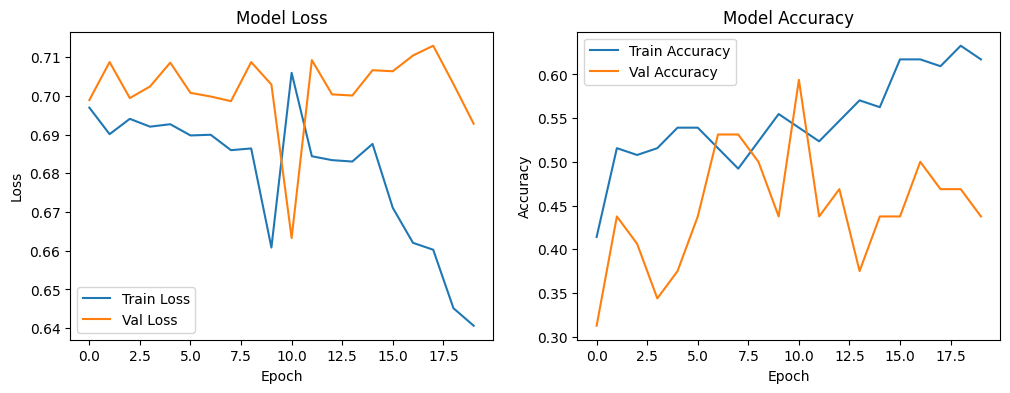

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6687 - loss: 0.6191
Test loss: 0.6161941289901733
Test accuracy: 0.675
Sensitivity (Recall): 0.5263157894736842
Specificity: 0.8095238095238095
F1 Score: 0.6060606060606061


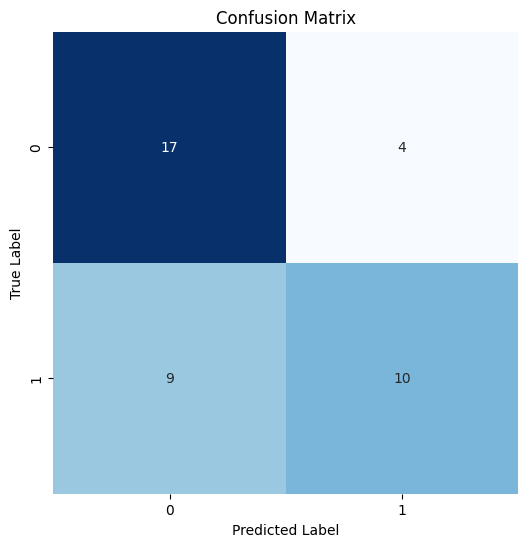

<Sequential name=sequential_5, built=True>

In [ ]:
# Load and preprocess data for classes B and D
classes = ['A', 'C']
X, y = prepare_data_for_classification(classes)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data for RNN
X = X.reshape(X.shape[0], X.shape[1], 1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the LSTM model
train_and_evaluate_lstm_model(X_train, y_train, X_test, y_test,
                              units1=200, units2=100,
                              dropout1=0.2, dropout2=0.3,
                              learning_rate=0.0005,
                              batch_size=16)

C-E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 4097, 140)           │          79,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 4097, 140)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 90)                  │          83,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 90)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              91 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,771 (635.82 KB)

 Trainable params: 162,771 (635.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 54s 13s/step - accuracy: 0.5698 - loss: 0.6857 - val_accuracy: 0.5938 - val_loss: 0.6746
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 47s 12s/step - accuracy: 0.5802 - loss: 0.6605 - val_accuracy: 0.5625 - val_loss: 0.6389
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 84s 13s/step - accuracy: 0.5906 - loss: 0.6182 - val_accuracy: 0.6562 - val_loss: 0.5632
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 12s/step - accuracy: 0.6625 - loss: 0.5973 - val_accuracy: 0.8750 - val_loss: 0.4554
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 84s 12s/step - accuracy: 0.8385 - loss: 0.4652 - val_accuracy: 0.9688 - val_loss: 0.2662
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 12s/step - accuracy: 0.9125 - loss: 0.3285 - val_accuracy: 0.9062 - val_loss: 0.2919
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - accuracy: 0.9375 - loss: 0.2386 - val_accuracy: 0.9062 - val_loss: 0.2715
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 85s 13s/step - accuracy: 0.8302 - loss: 0.4620 - val_accuracy: 0.8438 - val_loss: 0.2611


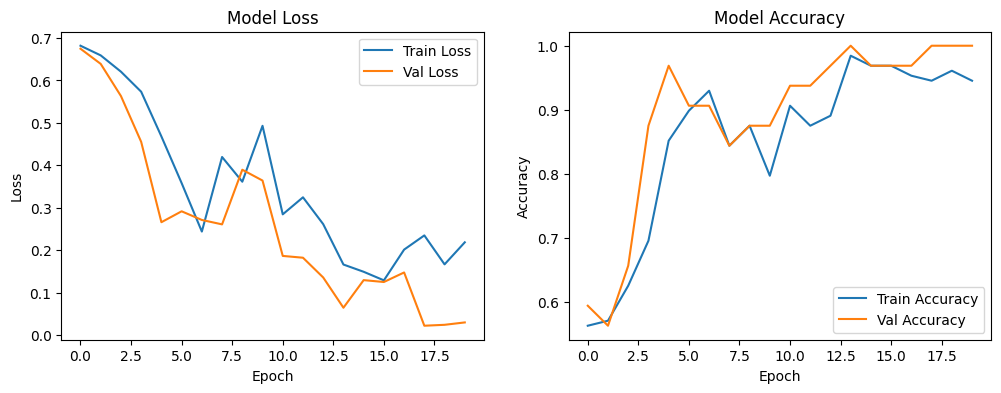

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9563 - loss: 0.1549
Test loss: 0.1733674257993698
Test accuracy: 0.95
Sensitivity (Recall): 1.0
Specificity: 0.9047619047619048
F1 Score: 0.9500000000000001


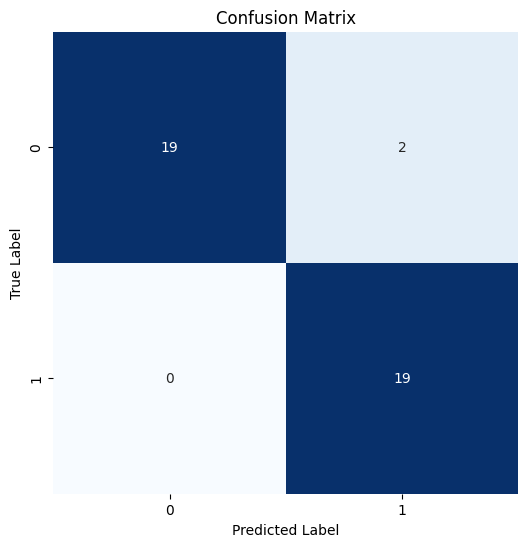

<Sequential name=sequential_6, built=True>

In [ ]:
# Load and preprocess data for classes C and E
classes = ['C', 'E']
X, y = prepare_data_for_classification(classes)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data for RNN
X = X.reshape(X.shape[0], X.shape[1], 1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate the LSTM model
train_and_evaluate_lstm_model(X_train, y_train, X_test, y_test, units1=140, units2=90, dropout1=0.3, dropout2=0.4, learning_rate=0.001, batch_size=32)
